# Create a projection from the IOC data

There a 3 components to a projection with the poses:
1. Features from the feature table (Feature Table)
2. A Projection (Projection table)
3. Mappings of the coordinates to the projection and features (MapProjectionFeature Table)

As the keypoints and angles are already provided in the associated feature data, the atlas is not needed to create the projection.

In [1]:
%cd ../..
%load_ext autoreload

%autoreload 2

/home/giacomo/projects/emplusvault


/home/giacomo/.cache/pypoetry/virtualenvs/emv-requDRed-py3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from emv.db.dao import DataAccessObject
from emv.db.queries import get_features_by_type_paginated, count_features_by_type
from sqlalchemy.sql import text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import numpy as np
from emv.api.models import Feature
from emv.api.models import Projection, MapProjectionFeatureCreate
from emv.db.queries import create_projection, create_map_projection_feature, create_feature, get_library_id_from_name, get_all_media_by_library_id
from umap import UMAP
import numba
from tqdm import tqdm

#from emv.features.pose import load_poses 
from emv.client.get_content import get_features
from emv.utils import dataframe_from_hdf5
from emv.settings import DRIVE_PATH

In [3]:
@numba.njit(fastmath=True)
def cylinder_euclidean_grad(x, y, cylinder_dimension=2*np.pi, linear_dimension=1.0):
    """Euclidean distance and gradient for cylindrical projection.

    x, y: Points between which the distance and gradient are computed.
    cylinder_dimension: The dimension of the cylindrical wraparound (default 2*pi).
    linear_dimension: The linear dimension (default 1.0).
    """
    distance_sqr = 0.0
    g = np.zeros_like(x)
    
    # Cylindrical dimension (e.g., angular wraparound)
    a = abs(x[0] - y[0])
    if 2 * a < cylinder_dimension:
        distance_sqr += a ** 2
        g[0] = (x[0] - y[0])
    else:
        distance_sqr += (cylinder_dimension - a) ** 2
        g[0] = (x[0] - y[0]) * (a - cylinder_dimension) / a
    
    # Linear dimension (e.g., height)
    b = abs(x[1] - y[1])
    distance_sqr += b ** 2
    g[1] = (x[1] - y[1])
    
    distance = np.sqrt(distance_sqr)
    return distance, g / (1e-6 + distance)

# Add filtered poses as new features to the DB

In [ ]:
local_poses_path = "data/sample_poses_to_keep.csv"
pose_df = load_poses(access_point="LOCAL", local_fp=local_poses_path, filter_poses={})
pose_df["angle_vec"] = pose_df.angle_vec_fix.map(lambda x: literal_eval(x))

In [ ]:
pose_df = pose_df[pose_df.keypoints.map(lambda x: x[7][2] > 0.5 and x[8][2] > 0.5)]
print(pose_df.shape)

In [ ]:
def centralize_and_scale_keypoints(keypoints, reference_points=['left_hip', 'right_hip'], target_diameter=1):

    keypoint_names = [
        'nose', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee',
        'left_ankle', 'right_ankle'
    ]
    keypoints = np.array(keypoints)

    # Calculate the reference point (midpoint between hips)
    left_hip = keypoints[keypoint_names.index(reference_points[0])]
    right_hip = keypoints[keypoint_names.index(reference_points[1])]
    center_point = (left_hip + right_hip) / 2

    # Translate pose to center it at the origin
    translated_keypoints = keypoints - center_point

    # Determine the maximum distance from the center point to any keypoint
    max_distance = np.max(np.linalg.norm(translated_keypoints, axis=1)) 

    # Calculate the scale factor to make the maximum distance equal to 0.5
    scale_factor = 0.5 / max_distance

    # Scale keypoints to have the target diameter
    scaled_keypoints = translated_keypoints * scale_factor

    return scaled_keypoints

def get_angle_feature_vector(keypoints):
    def calculate_angle(points):
        assert len(
            points) == 3, "Three points are required to calculate the angles"

        hip1, hip2, ref = np.array(points)

        if (hip1[0] == ref[0] and hip1[1] == ref[1]) or \
                (hip2[0] == ref[0] and hip2[1] == ref[1]) or \
                (hip1[0] == hip2[0] and hip1[1] == hip2[1]):
            return np.nan, np.nan, np.nan

        # Calculate the lengths of the sides of the triangle
        a = np.linalg.norm(hip2 - ref)
        b = np.linalg.norm(hip1 - ref)
        c = np.linalg.norm(hip1 - hip2)

        # Law of cosines to find the angles
        angle_hip2_hip1_ref = np.degrees(
            np.arccos((b**2 + c**2 - a**2) / (2 * b * c)))
        angle_hip1_hip2_ref = np.degrees(
            np.arccos((a**2 + c**2 - b**2) / (2 * a * c)))
        angle_hip1_ref_hip2 = np.degrees(
            np.arccos((a**2 + b**2 - c**2) / (2 * a * b)))

        return angle_hip2_hip1_ref, angle_hip1_hip2_ref, angle_hip1_ref_hip2

    angles = []

    # Using indices for reference points, these should be the two hips.
    ref_indices = [7, 8]  # Indices of the reference points

    # Calculate angles for each keypoint relative to the two reference points
    for i, keypoint in enumerate(keypoints):
        if i not in ref_indices:
            angles.extend(calculate_angle(
                [keypoints[ref_indices[0]], keypoint, keypoints[ref_indices[1]]]))

    feature_vector = np.array(angles)
    return feature_vector / 180.0

In [ ]:
pose_df["keypoints"] = pose_df.keypoints.map(lambda x: [list(k) for k in x])
pose_df["keypoints_norm"] = pose_df.keypoints.map(lambda x: centralize_and_scale_keypoints([k[:2] for k in x]))
pose_df["embedding_33"] = pose_df.keypoints_norm.map(lambda x: get_angle_feature_vector(x))

In [ ]:
pose_df = pose_df[pose_df.embedding_33.map(lambda x: not np.isnan(x).any())] # Remove poses with NaN angles
print(pose_df.shape)

In [ ]:
for i,row in pose_df.iloc.iterrows():
    feature = Feature(
        feature_type='pose_filtered',
        version="1",
        model_name='PifPafModel.fast',
        model_params={'PifPafModel': 'fast'},
        data={
            "frame":row["frame_number"],
            "sport":row["sport"],
            "keypoints":row["keypoints"],
            "keypoints_norm":row["keypoints_norm"].tolist()
            },
        media_id=row['media_id'], 
        embedding_size=33,
        embedding_33=row['embedding_33']
    )
    create_feature(feature)

# Load features from DB

## Load poses filtered

In [ ]:
# Retrieve the transformed features for the poses, feature_type = 'pose_image' is a smaller dataset than just 'pose'
# In comparison to the full data, it has normalized keypoints and embeddings
query = text("SELECT * FROM feature WHERE feature_type = 'pose_filtered'")
df = pd.DataFrame(DataAccessObject().fetch_all(query))
df['embedding_33'] = df['embedding_33'].apply(lambda x: literal_eval(x))
df["sport"] = df.data.map(lambda x: x["sport"])

print(f"{df.shape[0]} poses retrieved")

N_sample = 500
category = "sport"
sample_df = []
for label in df[category].unique():
    n_poses_in_sport = len(df[df[category] == label])
    if n_poses_in_sport < N_sample:
        sample_df.append(df[df[category] == label])
    else:
        sample_df.append(df[df[category] == label].sample(N_sample, random_state=42))
sample_df = pd.concat(sample_df)
sample_df = sample_df.reset_index(drop=True)
print(f"Testing with {len(sample_df)} poses.")

In [ ]:
df.head()

## Load all poses

In [ ]:
def centralize_and_scale_keypoints(keypoints, reference_points=['left_hip', 'right_hip'], target_diameter=1):

    keypoint_names = [
        'nose', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee',
        'left_ankle', 'right_ankle'
    ]
    keypoints = np.array(keypoints)

    # Calculate the reference point (midpoint between hips)
    left_hip = keypoints[keypoint_names.index(reference_points[0])]
    right_hip = keypoints[keypoint_names.index(reference_points[1])]
    center_point = (left_hip + right_hip) / 2

    # Translate pose to center it at the origin
    translated_keypoints = keypoints - center_point

    # Determine the maximum distance from the center point to any keypoint
    max_distance = np.max(np.linalg.norm(translated_keypoints, axis=1)) 

    # Calculate the scale factor to make the maximum distance equal to 0.5
    scale_factor = 0.5 / max_distance

    # Scale keypoints to have the target diameter
    scaled_keypoints = translated_keypoints * scale_factor

    return scaled_keypoints

def get_angle_feature_vector(keypoints):
    def calculate_angle(points):
        assert len(points) == 3, "Three points are required to calculate the angles"

        hip1, hip2, ref = np.array(points)

        if (hip1[0] == ref[0] and hip1[1] == ref[1]) or \
           (hip2[0] == ref[0] and hip2[1] == ref[1]) or \
           (hip1[0] == hip2[0] and hip1[1] == hip2[1]):
           return np.nan, np.nan, np.nan

        # Calculate the lengths of the sides of the triangle
        a = np.linalg.norm(hip2 - ref)
        b = np.linalg.norm(hip1 - ref)
        c = np.linalg.norm(hip1 - hip2)

        # Law of cosines to find the angles
        angle_hip2_hip1_ref = np.degrees(
            np.arccos((b**2 + c**2 - a**2) / (2 * b * c)))
        angle_hip1_hip2_ref = np.degrees(
            np.arccos((a**2 + c**2 - b**2) / (2 * a * c)))
        angle_hip1_ref_hip2 = np.degrees(
            np.arccos((a**2 + b**2 - c**2) / (2 * a * b)))

        return angle_hip2_hip1_ref, angle_hip1_hip2_ref, angle_hip1_ref_hip2

    angles = []

    # Using indices for reference points, these should be the two hips.
    ref_indices = [7, 8]  # Indices of the reference points

    # Calculate angles for each keypoint relative to the two reference points
    for i, keypoint in enumerate(keypoints):
        if i not in ref_indices:
            angles.extend(calculate_angle(
                [keypoints[ref_indices[0]], keypoint, keypoints[ref_indices[1]]]))

    feature_vector = np.array(angles)
    return feature_vector / 180.0

In [ ]:
MAX_FEATURES = 10000
poses = get_features_by_type_paginated("pose", page_size=1000)

while len(poses) < MAX_FEATURES:
    last_seen_id = poses[-1].get("feature_id", None)
    if last_seen_id is None:
        break
    poses.extend(get_features_by_type_paginated("pose", page_size=1000, last_seen_feature_id=last_seen_id))
    
print(f"Retrieved {len(poses)} instances")

In [ ]:
df = pd.DataFrame(poses)
df["frames"] = df["data"].map(lambda x: x["frames"])
df = df.explode("frames")

df["frame"] = df["frames"].map(lambda x: x["frame"])
df["annotations"] = df["frames"].map(lambda x: x["data"]["annotations"])
df = df.explode("annotations")

df.dropna(subset = ["annotations"], inplace=True)

df["score"] = df["annotations"].map(lambda x: x["score"])

# Cumulative sum of the scores binned by 0.05
df.score.hist(bins=20, cumulative=True)
plt.title(f"Cumulative score distribution on {len(df)} poses")
plt.show()

In [ ]:
df = df[df.score > 0.6]
metadata = pd.read_hdf("data/metadata.hdf5")
metadata["media_id"] = metadata.seq_id.map(lambda x: f"ioc-{x}")
df = df.merge(metadata[["media_id", "sport"]], on="media_id", how="left")

In [ ]:
N_sample = 10000
category = "sport"
sample_df = []
for label in df[category].unique():
    n_poses_in_sport = len(df[df[category] == label])
    if n_poses_in_sport < N_sample:
        sample_df.append(df[df[category] == label])
    else:
        sample_df.append(df[df[category] == label].sample(N_sample, random_state=42))
sample_df = pd.concat(sample_df)
sample_df = sample_df.reset_index(drop=True)
df = sample_df
print(f"Testing with {len(df)} poses.")

In [ ]:
df["bbox"] = df["annotations"].map(lambda x: x["bbox"])
df["keypoints"] = df["annotations"].map(lambda x: x["keypoints"])
df["keypoints"] = df["keypoints"].map(lambda x: [x[i:i+3] for i in range(0, len(x), 3)])
df["keypoints"] = df["keypoints"].map(lambda x: [k for i,k in enumerate(x) if i not in [1,2,3,4]]) # Remove eyes and ears
df["keypoints_norm"] = df["keypoints"].map(lambda x: centralize_and_scale_keypoints([k[:2] for k in x]))
df["embedding_33"] = df.keypoints_norm.map(lambda x: get_angle_feature_vector(x))
df = df[df.embedding_33.map(lambda x: not np.isnan(x).any())] # Remove poses with NaN angles

df = df[["media_id", "frame", "keypoints", "keypoints_norm", "embedding_33", "bbox", "score", "sport"]]

print(f"Retrieved {df.shape[0]} poses")

In [ ]:
df.head(2)

In [ ]:
df["feature_id"] = df.apply(lambda x: create_feature(Feature(
                                                        feature_type='pose_all',
                                                        version="1",
                                                        model_name='PifPafModel.fast',
                                                        model_params={'PifPafModel': 'fast'},
                                                        data={
                                                            "frame":x["frame"],
                                                            "sport":x["sport"],
                                                            "keypoints":x["keypoints"],
                                                            "keypoints_norm":x["keypoints_norm"].tolist()
                                                            },
                                                        media_id=x['media_id'], 
                                                        embedding_size=33,
                                                        embedding_33=x['embedding_33'].tolist()
                                                    )), axis=1)

In [ ]:
df["feature_id"] = df["feature_id"].map(lambda x: x.get("feature_id", None))

# Create projection

In [ ]:
# default values that assume an atlas, not necessary, 
# but it's good to give the correct values when creating the projection

total_tiles = len(df) # either all features or a subset of features
atlas_width = 4096
max_tile_size = 512
max_tiles_per_atlas = (atlas_width // max_tile_size) ** 2
atlas_count = int(total_tiles / max_tiles_per_atlas) + 1

## Cylindrical Projection

In [ ]:
cylinder_mapper = UMAP(output_metric=cylinder_euclidean_grad, min_dist=0.1, n_neighbors=100, random_state=42)
data = np.array(df['embedding_33'].tolist())
embedding = cylinder_mapper.fit_transform(data)

In [ ]:
color_palette = sns.color_palette("Set2", n_colors=len(df.sport.unique()))
colors = df.sport.map(lambda x: color_palette[list(df.sport.unique()).index(x)])

In [ ]:
# Panorama dimensions
R_pano = 1
H_pano = 1

# Cylindrical dimension (theta) and height (h)
cylinder_dimension = 2 * np.pi
radius = R_pano  # Radius of the cylinder

# Extract the cylindrical (theta) and linear (h) coordinates
theta_coords = cylinder_mapper.embedding_[:, 0] % cylinder_dimension
h_coords = cylinder_mapper.embedding_[:, 1]
h_coords = H_pano * (h_coords - np.min(h_coords)) / (np.max(h_coords) - np.min(h_coords)) # Remap height to [0, H_pano] size of the Panorama

# Convert cylindrical coordinates to Cartesian coordinates
x = radius * np.cos(theta_coords)
y = radius * np.sin(theta_coords)
z = h_coords

embedding_cartesian = np.stack([x, y, z], axis=1)

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, z, s = 0.1)
ax1.set_title("Cylindrical projection", fontweight = "bold")

ax2 = fig.add_subplot(122)
ax2.scatter(theta_coords, h_coords, s = 0.1)
ax2.set_title("Unwrapped cylinder", fontweight = "bold")

plt.tight_layout()
plt.show()

In [ ]:
# Create the projection, replace the names with the desired ones, library_id = 2 is for the IOC
projection = Projection(
    projection_name="IOC Poses All Cylindrical UMAP 1",
    version="0.0.1",
    library_id=2,
    model_name="openpifpaf_fast",
    model_params={},
    data={},
    dimension=3,
    atlas_folder_path="",
    atlas_width=atlas_width,
    tile_size=max_tile_size,
    atlas_count=atlas_count,
    total_tiles=total_tiles,
    tiles_per_atlas=max_tiles_per_atlas,
)

projection_id = create_projection(projection)['projection_id']
print(f"Projection ID: {projection_id}")

In [ ]:
# Create an entry in the map_projection_feature table for each feature, links features, media and coordinates
for i, row in df.iterrows():
    create_map_projection_feature(MapProjectionFeatureCreate(
        projection_id=projection_id,
        media_id=row.media_id,
        atlas_order=-1,
        index_in_atlas=-1,
        coordinates=[embedding_cartesian[i, 0], embedding_cartesian[i, 1], embedding_cartesian[i, 2]],
        feature_id=row.feature_id
    ))

## 3D Projection

In [ ]:
threed_mapper = UMAP(n_components=3, min_dist=0.1, n_neighbors=100, random_state=42)
data = np.array(df['embedding_33'].tolist())
embedding_threed = threed_mapper.fit_transform(data)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(embedding_threed[:, 0], embedding_threed[:, 1], embedding_threed[:, 2], c=colors, s = 0.1)
plt.show()

In [ ]:
# Create the projection, replace the names with the desired ones, library_id = 2 is for the IOC
projection = Projection(
    projection_name="IOC Poses Filtered 3D UMAP",
    version="0.0.1",
    library_id=2,
    model_name="openpifpaf_fast",
    model_params={},
    data={},
    dimension=3,
    atlas_folder_path="",
    atlas_width=atlas_width,
    tile_size=max_tile_size,
    atlas_count=atlas_count,
    total_tiles=total_tiles,
    tiles_per_atlas=max_tiles_per_atlas,
)

projection_id = create_projection(projection)['projection_id']
print(f"Projection ID: {projection_id}")

In [ ]:
# Create an entry in the map_projection_feature table for each feature, links features, media and coordinates
for i, row in df.iterrows():
    create_map_projection_feature(MapProjectionFeatureCreate(
        projection_id=projection_id,
        media_id=row.media_id,
        atlas_order=-1,
        index_in_atlas=-1,
        coordinates=[embedding_threed[i, 0], embedding_threed[i, 1], embedding_threed[i, 2]],
        feature_id=row.feature_id
    ))

# Binary files Projection

In [4]:
total_features = count_features_by_type("pose-binary-extracted")
print(f"Total features: {total_features}")

Total features: 181417


In [5]:
MAX_FEATURES = total_features + 1
data = get_features_by_type_paginated("pose-binary-extracted", page_size=10000)

for _ in tqdm(range(MAX_FEATURES // 10000)):
    last_seen_id = data[-1].get("feature_id", None)
    if last_seen_id is None:
        break
    data.extend(get_features_by_type_paginated("pose-binary-extracted", page_size=10000, last_seen_feature_id=last_seen_id))

100%|██████████| 18/18 [00:12<00:00,  1.41it/s]


In [6]:
data = pd.DataFrame(data)

In [10]:
ioc_metadata = pd.read_hdf("data/metadata.hdf5")

In [11]:
ioc_metadata["media_id"] = ioc_metadata.seq_id.map(lambda x: f"ioc-{x}")
data = data.merge(ioc_metadata[["media_id", "sport"]], on="media_id", how="left")

In [17]:
data.sport.value_counts()[:5].sum() / len(data.sport) * 100

71.2728134629059

In [11]:
cylinder_mapper = UMAP(output_metric=cylinder_euclidean_grad, min_dist=0.1, n_neighbors=100, random_state=42)
features = np.array(data['embedding_33'].tolist())
embedding = cylinder_mapper.fit_transform(features)

/home/giacomo/.cache/pypoetry/virtualenvs/emv-requDRed-py3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [19]:
data["projection"] = embedding.tolist()

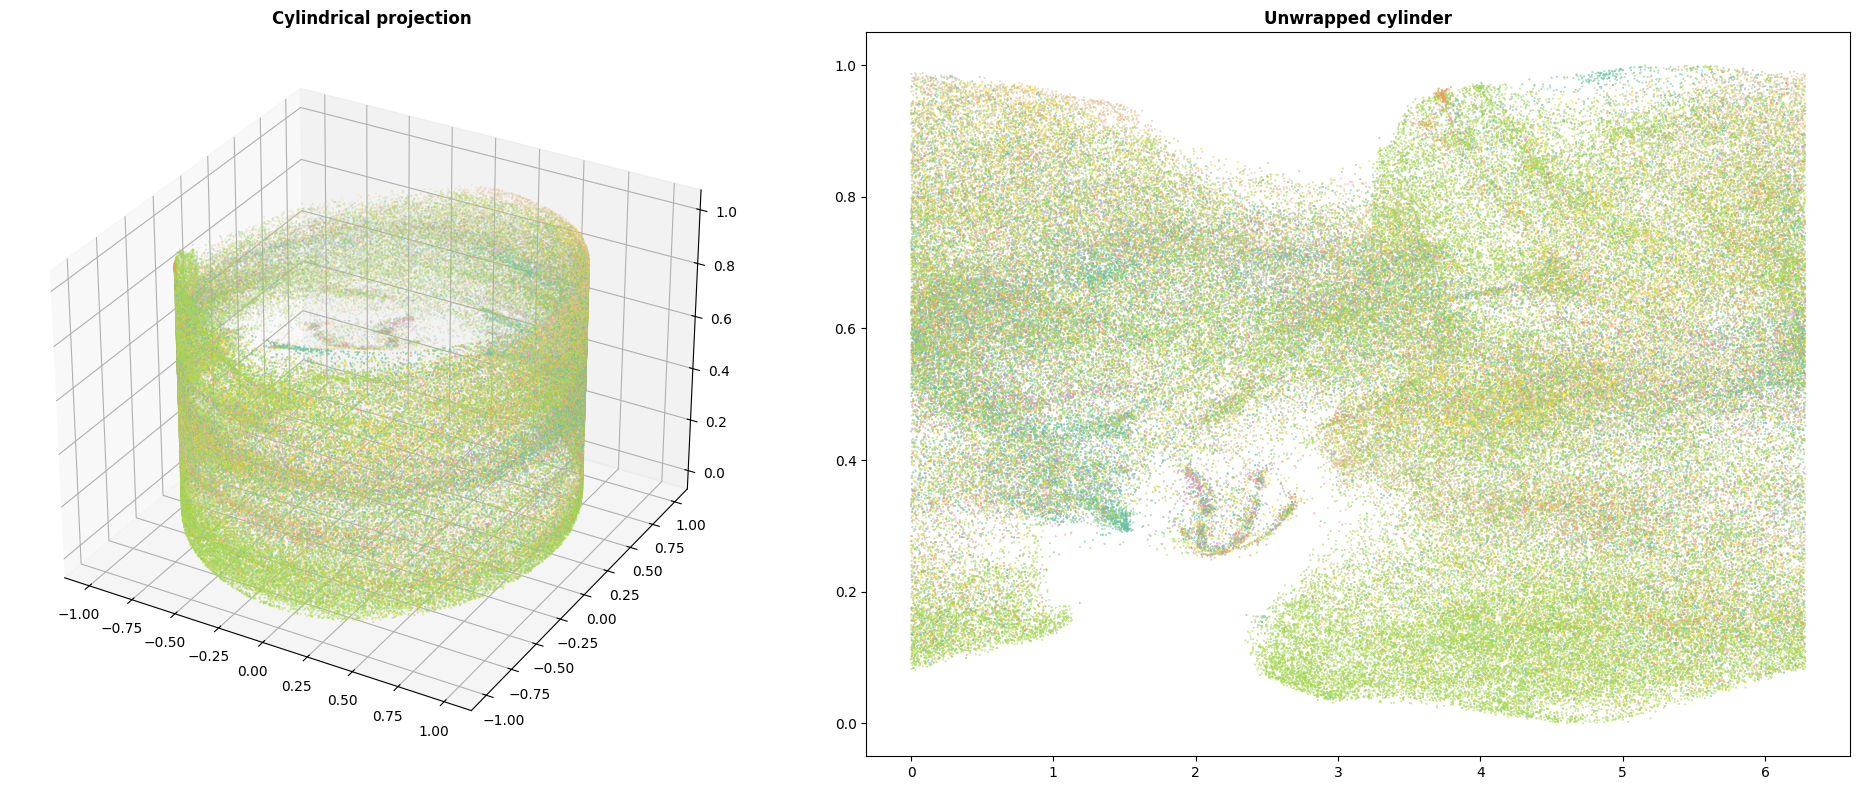

In [21]:
# Panorama dimensions
R_pano = 1
H_pano = 1

# Cylindrical dimension (theta) and height (h)
cylinder_dimension = 2 * np.pi
radius = R_pano  # Radius of the cylinder

# Extract the cylindrical (theta) and linear (h) coordinates
theta_coords = cylinder_mapper.embedding_[:, 0] % cylinder_dimension
h_coords = cylinder_mapper.embedding_[:, 1]
h_coords = H_pano * (h_coords - np.min(h_coords)) / (np.max(h_coords) - np.min(h_coords)) # Remap height to [0, H_pano] size of the Panorama

# Convert cylindrical coordinates to Cartesian coordinates
x = radius * np.cos(theta_coords)
y = radius * np.sin(theta_coords)
z = h_coords

embedding_cartesian = np.stack([x, y, z], axis=1)

# Map sports to colors
color_palette = sns.color_palette("Set2", n_colors=len(data.sport.unique()))
colors = data.sport.map(lambda x: color_palette[list(data.sport.unique()).index(x)])

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, z, c=colors, s=0.1)
ax1.set_title("Cylindrical projection", fontweight="bold")

ax2 = fig.add_subplot(122)
ax2.scatter(theta_coords, h_coords, c=colors, s=0.1)
ax2.set_title("Unwrapped cylinder", fontweight="bold")

plt.tight_layout()
plt.show()

In [14]:
binary_poses = get_features_by_type_paginated("pose-binary", page_size=1000)

In [15]:
binary_poses[0]

{'feature_id': 2449503, 'feature_type': 'pose-binary', 'version': '1', 'created_at': datetime.datetime(2025, 3, 18, 14, 29, 21, 812054), 'model_name': 'binary', 'model_params': {}, 'data': {}, 'embedding_size': 0, 'embedding_1024': None, 'embedding_1536': None, 'embedding_2048': None, 'media_id': 'ioc-SEQ41430642-binary', 'embedding_33': None, 'embedding_16': None}

In [4]:
lib_id = get_library_id_from_name("ioc")
binary = get_all_media_by_library_id(lib_id, page_size = 1000, media_type = "video", sub_type = "binary")

In [5]:
binary[0]

{'media_id': 'ioc-SEQ41430642-binary', 'media_path': 'pose_binaries/MDA30021100/SEQ41430642.bin', 'original_path': 'pose_binaries/MDA30021100/SEQ41430642.bin', 'original_id': 'MDA30021100', 'created_at': datetime.datetime(2025, 3, 18, 14, 29, 20, 948590), 'media_type': 'video', 'media_info': {'resolution': [288, 512]}, 'sub_type': 'binary', 'size': -1, 'metadata': None, 'library_id': 2, 'hash': '6af69dac9363ad0531652229927aa692', 'parent_id': 'ioc-SEQ41430642', 'start_ts': 0.0, 'end_ts': 0.0, 'start_frame': 0, 'end_frame': -1, 'frame_rate': -1.0}